# Tutorial: Optimization

## Computational Economics  (ECO309)

In this tutorial you will learn to code and use common optimization algorithms for static models.


---

## Profit optimization by a monopolist

A monopolist produces quantity $q$ of goods X at price $p$. Its cost function is $c(q) = 0.5 + q (1-qe^{-q})$

The consumer's demand for price $p$ is $x(p)=2 e^{-0.5 p}$ (constant elasticity of demand to price).

__Write down the profit function of the monopolist and find the optimal production (if any). Don't use any library except for plotting.__



Assume the monopolist decides on the optimal quantity $q$.
Price at this quantity is determined by demand: $p(x) = -2 \log\left( \frac{x}{2} \right)$

Profit function $\pi(q) = \underbrace{R(q)}_{\text{revenue}} - c(q) = q * p(q) - c(q)$

In [7]:
p(q) = -2log(q/2)
c(q) = 0.5 + q*(1-q*exp(-q))
R(q) = q*p(q)
profits(q) = R(q) - c(q)

profits (generic function with 1 method)

In [8]:
using Plots

In [10]:
qvec = range(0.1, 1; length=100)

0.1:0.00909090909090909:1.0

In [14]:
profits.(qvec);

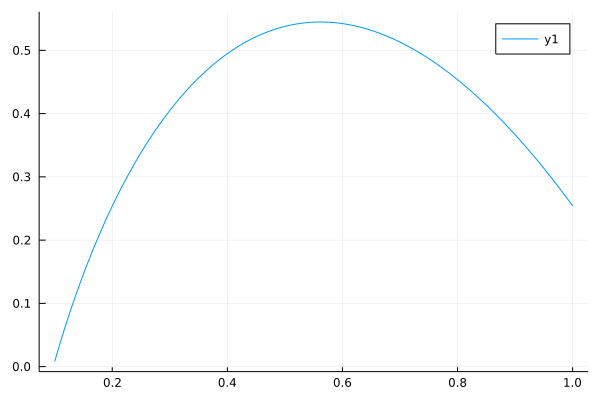

In [15]:
plot(qvec, profits.(qvec))

In [45]:
function golden(f, a, b; fa=f(a), fb=f(b), Φ=0.3, ϵ=1e-5)
    if abs(b-a)<ϵ
        return (a+b)/2
    end
    c = a + Φ*(b-a)
    d = a + (1-Φ)*(b-a)
    fc = f(c)
    fd = f(d)
    # I need to choose between [a,c,d] or [c,d,b]
    if (fc>=fa && fc>=fd)
        return golden(f, a, d; fa=fa, fb=fd, Φ=Φ, ϵ=ϵ)
    elseif (fd>fc && fd>fb)
        return golden(f, c, b; fa=fc, fb=fb, Φ=Φ, ϵ=ϵ)
    else
        # here I should return a or b
        throw("Incorrect function: does not contain an unconstrained local maximum")
    end
end


golden (generic function with 1 method)

In [46]:
qopt = golden(profits, 0.2, 1.0)

0.5618586881082992

┌ Warning: Skipped marker arg o.
└ @ Plots /home/pablo/.julia/packages/Plots/SVksJ/src/args.jl:873


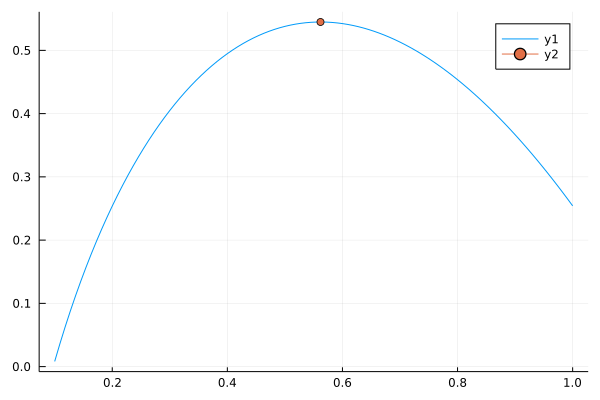

In [48]:
pl = plot(qvec, profits.(qvec))
plot!([qopt], [profits(qopt)], marker="o")


Alternative approach: define 

$\pi^{\prime} = r^{\prime}(q) - c^{\prime}(q)$

Look for a zero $\pi^{\prime}(q) = 0$.

If we do that, we need to check that it is indeed a maximum and that profits are positive.

---

## Constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

__Use Optim.jl to minimize $f$ without constraint. Check you understand diagnostic information returned by the optimizer.__

In [2]:
using Optim

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


In [4]:
f(x::Vector{Float64}) = 1- (x[1]-0.5)^2 - (x[2]-0.3)^2

f (generic function with 1 method)

In [26]:
x0 = [0.0, 0.0]
result = Optim.optimize(u->-f(u), x0, Newton())

 * Status: success

 * Candidate solution
    Final objective value:     -1.000000e+00

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 5.00e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.40e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.40e-01 ≰ 0.0e+00
    |g(x)|                 = 1.65e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    4
    ∇f(x) calls:   4
    ∇²f(x) calls:  1


In [23]:
result.minimizer

2-element Array{Float64,1}:
 0.5000172833186103
 0.2999408484491455

__Now, consider the constraint $x<0.3$ and maximize $f$ under this new constraint.__

In [27]:
lower = [-Inf, -Inf]
upper = [0.3, Inf]

2-element Array{Float64,1}:
  0.3
 Inf

In [29]:
x0

2-element Array{Float64,1}:
 0.0
 0.0

In [31]:
result_bounded = Optim.optimize(u->-f(u), lower, upper, x0)

 * Status: success

 * Candidate solution
    Final objective value:     -9.600000e-01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.20e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.83e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    56
    ∇f(x) calls:   56


In [32]:
result_bounded.minimizer

2-element Array{Float64,1}:
 0.2999999988
 0.29999999999995636

__Reformulate the problem as a root finding problem with lagrangians. Write the complementarity conditions.__

__Solve using NLSolve.jl__

---

## Consumption optimization

A consumer has preferences $U(c_1, c_2)$ over two consumption goods $c_1$ and $c_2$.

Given a budget $I$, consumer wants to maximize utility subject to the budget constraint $p_1 c_1 + p_2 c_2 \leq I$.

We choose a Stone-Geary specification where

$U(c_1, c_2)=\beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2)$

__Write the Karush-Kuhn-Tucker necessary conditions for the problem.__

__Verify the KKT conditions are sufficient for optimality.__

__Derive analytically the demand functions, and the shadow price.__

__Interpret this problem as a complementarity problem and solve it using NLSolve.__

__Produce some nice graphs with isoutility curves, the budget constraint and the optimal choice.__

